In [198]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql.functions import isnan, when, count, col
from os.path import expanduser, join, abspath

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.conf import SparkConf
%matplotlib inline
plt.style.use('ggplot')


In [199]:
# Initialization
# warehouse_location = abspath('spark-warehouse')
# .config("spark.sql.warehouse.dir", warehouse_location) \
# .config("spark.dynamicAllocation.enabled","true") \

spark = SparkSession\
    .builder \
    .appName("NYC-taxi-spark") \
    .enableHiveSupport() \
    .getOrCreate()

In [200]:
# Location of data in Filesystem  
trips_file_loc = "/home/nyc_taxi_data/trips"
weather_loc = "/home/nyc_taxi_data/weather"
stations_loc = "/home/nyc_taxi_data/weather_stations"

In [201]:
# READ IN TRIP DATA FRAME FROM CSV
# Mention read from Hadoop 
start = time.time()
trips_df = spark.read.csv(path=trips_file_loc, header=True, inferSchema=a=True)
weather_df = spark.read.csv(path=weather_loc, header=True, inferSchema=True)
weather_stations_df = spark.read.csv(path=stations_loc, header=True, inferSchema=True)
print(f"... completed job in {time.time() - start} seconds")

... completed job in 210.48971366882324 seconds


In [202]:
trips_df.count()

53925735

In [203]:
# Data Expolration
trips_df.printSchema()
trips_df.dtypes
trips_df.count()

weather_df.printSchema()
weather_df.dtypes
# weather_df.count()

weather_stations_df.printSchema()
weather_stations_df.dtypes
# weather_stations_df.count()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

root
 |-- stn: integer (nullable = true)
 |-- wban: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- mo: integer (nullable = true)
 |-- da: integer (nullable = true)
 |-- temp: double (nullable = true

[('usaf', 'string'),
 ('wban', 'int'),
 ('name', 'string'),
 ('country', 'string'),
 ('state', 'string'),
 ('call', 'string'),
 ('lat', 'double'),
 ('lon', 'double'),
 ('elev', 'double'),
 ('begin', 'int'),
 ('end', 'int')]

In [204]:
# Write to External tables
# spark.sql("
# CREATE EXTERNAL TABLE yellow_taxi_2015_01 (
#     vendorID                    VARCHAR(3),
#     pickup_datetime             TIMESTAMP,
#     dropoff_datetime            TIMESTAMP,
#     passenger_count             SMALLINT,
#     trip_distance               DECIMAL(6,3),
#     pickup_longitude            DECIMAL(9,6),
#     pickup_latitude             DECIMAL(9,6),
#     ratecodeID                  SMALLINT,
#     store_and_fwd_flag          VARCHAR(1),
#     dropoff_longitude           DECIMAL(9,6),
#     dropoff_latitude            DECIMAL(9,6),
#     payment_type                VARCHAR(3),
#     fare_amount                 DECIMAL(6,2),
#     extra                       DECIMAL(6,2),
#     mta_tax                     DECIMAL(6,2),
#     tip_amount                  DECIMAL(6,2),
#     tolls_amount                DECIMAL(6,2),
#     improvement_surcharge       DECIMAL(6,2),
#     total_amount                DECIMAL(6,2)
# )
# ROW FORMAT DELIMITED
# FIELDS TERMINATED BY ','
# LINES TERMINATED BY '\n'
# LOCATION '/home/nyc_taxi_data/trips'")
# you can check by ls the directory
start = time.time()
trips_df.write.mode("overwrite").option("path","/home/external-tables").saveAsTable("trips")
weather_stations_df.write.mode("overwrite").option("path","/home/external-tables").saveAsTable("weather_stations")
weather_df.write.mode("overwrite").option("path","/home/external-tables").saveAsTable("weather")
print(f"... completed job in {time.time() - start} seconds")


... completed job in 306.1724519729614 seconds


In [217]:
query="""select count(*) from trips"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|53925735|
+--------+



In [205]:
# register temp table so it can be queried with SQL
trips_df.registerTempTable("trips")
weather_stations_df.registerTempTable("weather_stations")
weather_df.registerTempTable("weather")

In [206]:
# Filtering Out Problematic Data
# Join in all the loaded DataFrames into one
query = """
WITH daily_weather AS (
  SELECT
    TO_DATE(
      CAST(
        UNIX_TIMESTAMP(CONCAT(w.mo, '/', w.da, '/', w.year), 'MM/dd/yyyy') AS TIMESTAMP
      )
    ) AS weather_date,
    w.temp AS avg_temp
  FROM
    weather w
  WHERE
    w.wban IN (
      SELECT
        ws.wban
      FROM
        weather_stations ws
      WHERE
        ws.country = 'US'
        AND ws.state = 'NY'
        AND ws.call = 'KNYC'
    )
),
yellow_trips AS (
  SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) AS pickup_date,
    t.tpep_pickup_datetime AS pickup_datetime,
    TO_DATE(t.tpep_dropoff_datetime) AS dropoff_date,
    t.tpep_dropoff_datetime AS dropoff_datetime,
    t.passenger_count,
    t.trip_distance,
    t.RatecodeID as rate_code,
    t.store_and_fwd_flag,
    t.PULocationID as pickup_location_id,
    t.DOLocationID as dropoff_location_id,
    t.payment_type,
    t.total_amount
  FROM
    trips t
)
SELECT
  yt.vendor_id,
  yt.pickup_date,
  yt.pickup_datetime,
  yt.dropoff_date,
  yt.dropoff_datetime,
  yt.passenger_count,
  yt.trip_distance,
  yt.total_amount,
  yt.pickup_location_id,
  yt.dropoff_location_id,
  CASE WHEN dw.avg_temp >=-58 and dw.avg_temp <=32 THEN 'Freezing'
         WHEN dw.avg_temp >=33 and dw.avg_temp <=50 THEN 'Cold'
         WHEN dw.avg_temp >=51 and dw.avg_temp <=68 THEN 'Warm'
         WHEN dw.avg_temp >=69 and dw.avg_temp <=131 THEN 'HOT'
         END AS weather
FROM
  yellow_trips yt
  LEFT JOIN daily_weather dw ON (dw.weather_date = yt.pickup_date)
WHERE 
    yt.total_amount < 10000
    AND yt.total_amount > 0
    AND yt.trip_distance < 1000
    AND yt.trip_distance > 0
    AND yt.passenger_count < 100
    AND yt.pickup_date >= '2018-01-01'
    AND yt.pickup_date < '2018-07-01'
    AND dw.avg_temp >= -58
    AND dw.avg_temp <=131
"""

# create a new DataFrame based on the query
combo_df = spark.sql(query)

# Register the new DataFrame 
combo_df.registerTempTable("comb")


In [207]:
combo_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- weather: string (nullable = true)



In [208]:
combo_df.select("total_amount").describe().toPandas()

,summary,total_amount
0,count,53554416
1,mean,16.05897779654541
2,stddev,14.051510701954975
3,min,0.3
4,max,8019.6


In [209]:
combo_df.select("trip_distance").describe().toPandas()

,summary,trip_distance
0,count,53554416
1,mean,2.917112506837914
2,stddev,3.7538373324761
3,min,0.01
4,max,943.5


In [210]:
combo_df.select("passenger_count").describe().toPandas()

,summary,passenger_count
0,count,53554416
1,mean,1.6013468991987514
2,stddev,1.2491955704267848
3,min,0
4,max,9


In [211]:
# Data quality check
query = """
SELECT
    DATE_TRUNC('MM', c.pickup_datetime) AS trip_month,
    COUNT(1) AS trip_count
FROM
    comb c
GROUP BY
    trip_month
"""

start = time.time()
pd_df = spark.sql(query).toPandas()
print(f"... completed job in {time.time() - start} seconds")
# from pyspark.sql.functions import sum as _sum


... completed job in 165.35308051109314 seconds


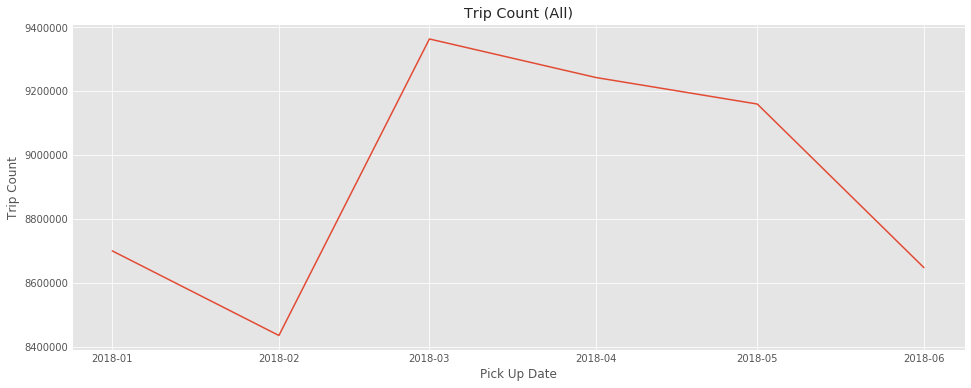

In [212]:
# Plot out the daily trip count
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x='trip_month', y='trip_count', data=pd_df, ax=ax)

ax.set_title("Trip Count (All)")
ax.set_ylabel("Trip Count")
ax.set_xlabel("Pick Up Date")

plt.show()

In [213]:
# How does the weather affect trips per day
query = """
SELECT
    c.weather,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trip_count,
    MEAN(c.trip_distance) AS mean_trip_distance,
    ROUND(MEAN((unix_timestamp(c.dropoff_datetime) - unix_timestamp(c.pickup_datetime))/60),
          2) AS mean_traveltime_min,
    ROUND(MEAN(c.trip_distance/((unix_timestamp(c.dropoff_datetime) - unix_timestamp(c.pickup_datetime))/3600)),
               2) AS mean_travelspeed_mph
FROM
    comb c
GROUP BY
    c.weather,
    day_of_week

"""

start = time.time()
pd_df = spark.sql(query).toPandas()
print(f"... completed job in {time.time() - start} seconds")

... completed job in 300.55413484573364 seconds


In [214]:
pd_df.head(10)

,weather,day_of_week,trip_count,mean_trip_distance,mean_traveltime_min,mean_travelspeed_mph
0,Warm,Thursday,2587988,2.959173,18.19,12.04
1,Warm,Monday,1597787,3.195884,16.67,14.00
2,HOT,Thursday,1557013,2.990824,19.10,12.00
3,HOT,Friday,2112054,3.013212,18.24,13.15
4,None,Wednesday,624406,2.713547,17.03,11.65
5,None,Tuesday,315708,2.660555,16.35,11.99
6,Cold,Wednesday,3544283,2.747022,16.13,12.47
7,Cold,Monday,3853858,2.992249,15.68,14.06
8,Freezing,Saturday,593831,2.633627,15.18,13.25
9,HOT,Sunday,487354,3.390388,17.05,15.79


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

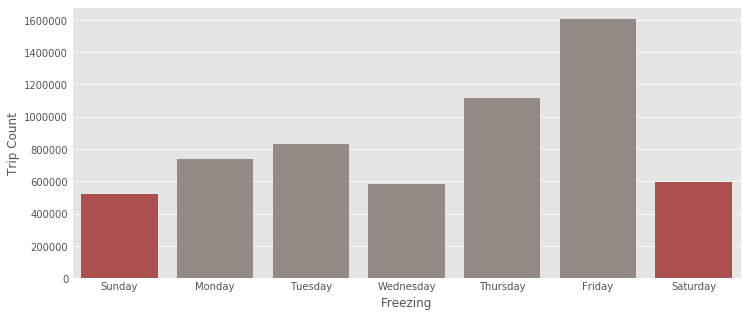

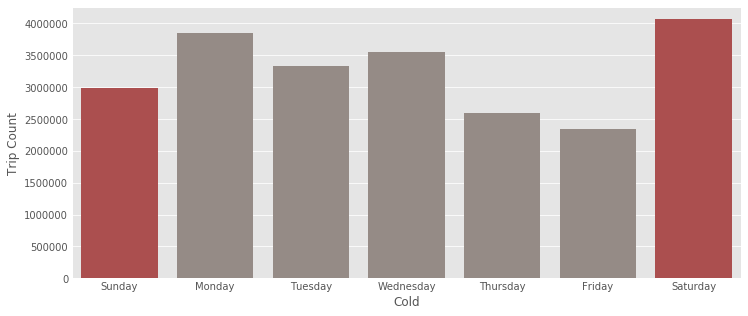

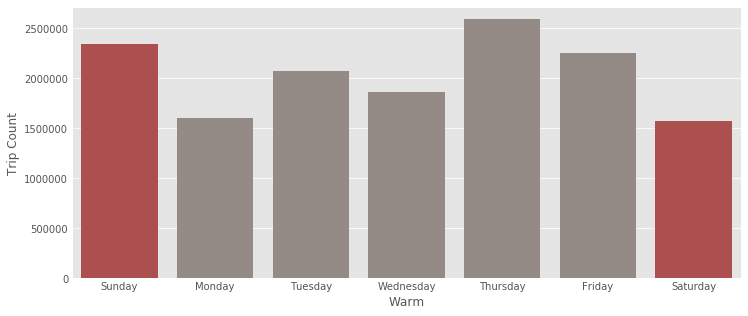

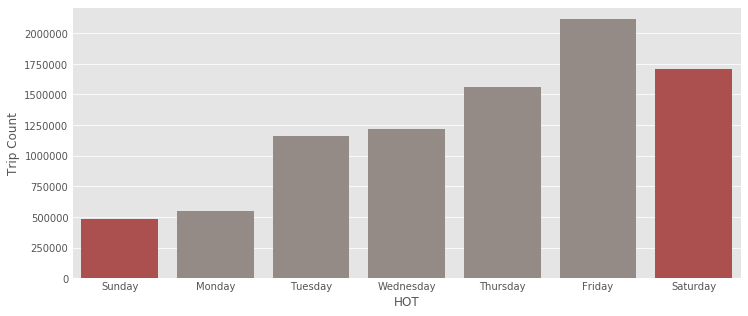

In [215]:
for weather in ["Freezing","Cold","Warm", "HOT"]:
    
    data = pd_df.loc[pd_df['weather'] == weather]
    # indicator for weekend vs. weekday so we can color it differently in the plot.
    data["weekend_ind"] = data.day_of_week.apply(lambda x: 1 if (x == "Saturday" or x == "Sunday") else 0)

    data["sort_dow"] = data["day_of_week"].replace({"Sunday":0, 
                                                    "Monday":1,
                                                    "Tuesday":2,
                                                    "Wednesday":3,
                                                    "Thursday":4,
                                                    "Friday": 5,
                                                    "Saturday":6})


    # sort the pd datfarame so that it shows up nicely in the plot
    data.sort_values(by="sort_dow", inplace=True)

    fig, ax = plt.subplots(figsize=(12,5))
    sns.barplot(x="day_of_week",
                y="trip_count",
                palette=["#978a84", "#bb3f3f"],
                data=data,
                hue="weekend_ind",
                dodge=False, ax=ax)

    # remove legend and change labels
    ax.get_legend().remove()
    ax.set_ylabel("Trip Count")
    ax.set_xlabel(weather)

    # show the plot!
    plt.show()
